# Baselines

## Import Dependencies

In [1]:
#import dependencies
! pip install tensorboardX
! pip install numpy-quaternion

Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.
Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [2]:
import os
import time
from os import path as osp

import numpy as np
import torch
import json
import math
import xgboost as xg


import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
from tensorboardX import SummaryWriter
from torch.utils.data import DataLoader

from data_Oxiod import *
from transformations import *
from metric import compute_ate_rte
from model_resnet1d import *

ModuleNotFoundError: No module named 'torch'

## Extended Kalman Filter

In [24]:
import pandas as pd
data = pd.read_csv('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handbag/data1/combined1.csv')

In [25]:
data

,rotation_rate_x(radians/s),rotation_rate_y(radians/s),rotation_rate_z(radians/s),user_acc_x(G),user_acc_y(G),user_acc_z(G),translation.x,translation.y,translation.z,rotation.x,rotation.y,rotation.z,rotation.w
0,0.011675,-0.044659,0.004123,-0.006020,-0.007752,-0.019776,-0.35230,1.936300,0.64004,-0.60368,0.35567,-0.34964,0.62194
1,0.017045,-0.039372,0.004127,-0.000972,0.003804,-0.022116,-0.35226,1.936300,0.64003,-0.60368,0.35591,-0.34973,0.62176
2,0.016019,-0.034032,0.003053,-0.003001,0.001363,-0.020956,-0.35219,1.936300,0.64004,-0.60382,0.35603,-0.34971,0.62157
3,0.007559,-0.026496,-0.001240,-0.002679,-0.000947,-0.019943,-0.35216,1.936200,0.64003,-0.60381,0.35607,-0.34976,0.62153
4,0.001269,-0.015779,-0.007669,-0.004189,-0.007488,-0.019378,-0.35209,1.936200,0.64007,-0.60406,0.35617,-0.34967,0.62127
...,...,...,...,...,...,...,...,...,...,...,...,...,...
57494,-0.031251,-0.222120,-0.122810,-0.019891,-0.164330,0.060818,-0.68697,0.065166,0.58907,-0.65617,-0.27365,0.25544,0.65521
57495,-0.035393,-0.189080,-0.095123,-0.018112,-0.182130,0.064257,-0.68005,0.071336,0.58913,-0.65639,-0.27289,0.25493,0.65551
57496,-0.051204,-0.146360,-0.065339,-0.015627,-0.184370,0.067860,-0.67321,0.077152,0.59001,-0.65617,-0.27206,0.25411,0.65639
57497,-0.073430,-0.104650,-0.034496,-0.013299,-0.173480,0.073141,-0.66572,0.083231,0.58989,-0.65703,-0.27228,0.25329,0.65575


### Preprocessing
- Convert quaternion data into euler orientation (ground truth data)
- Convert acceleration (G) to acceleration (m/s^2)

In [21]:
from scipy.spatial.transform import Rotation

quaternion = data[['rotation.w', 'rotation.x', 'rotation.y', 'rotation.z']].values

print(quaternion.shape)

# Create a rotation object from the quaternion
rotation = Rotation.from_quat(quaternion)

# Convert the quaternion to Euler angles
euler_orientations = rotation.as_euler('xyz', degrees= False)

# Print the Euler angles
print(euler_orientations)

(33016, 4)
[[ 0.39250605 -0.12061707 -1.64737255]
 [ 0.39698531 -0.1241574  -1.64241244]
 [ 0.3966826  -0.12408793 -1.64263756]
 ...
 [-2.4097472  -0.09723274 -0.38935567]
 [-2.41069797 -0.0947308  -0.38841608]
 [-2.41190174 -0.09305428 -0.38702691]]


In [22]:
acc = data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']].values
acc = acc * 9.81
print('acceleration: ', acc)
print(acc)

acceleration:  [[-8.1629010e-02 -8.3090700e-03 -2.1091500e-03]
 [-6.0105870e-02  2.4917400e-03  1.0712520e-02]
 [-4.2006420e-02  1.7658000e-04  1.3449510e-02]
 ...
 [-2.2708188e-01 -6.7907763e-01 -4.4803251e-01]
 [-2.4238548e-01 -6.9911946e-01 -4.3702569e-01]
 [-8.5621680e-02 -7.6408128e-01 -3.3044985e-01]]
[[-8.1629010e-02 -8.3090700e-03 -2.1091500e-03]
 [-6.0105870e-02  2.4917400e-03  1.0712520e-02]
 [-4.2006420e-02  1.7658000e-04  1.3449510e-02]
 ...
 [-2.2708188e-01 -6.7907763e-01 -4.4803251e-01]
 [-2.4238548e-01 -6.9911946e-01 -4.3702569e-01]
 [-8.5621680e-02 -7.6408128e-01 -3.3044985e-01]]


In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation


class ExtendedKalmanFilter:
    """Extended Kalman Filter for tracking a human with IMU measurements"""

    def __init__(self, x, P):
        """Initialize the Kalman Filter

        Args:
            x (numpy.array): Initial state estimate
            P (numpy.array): Initial error covariance matrix
        """
        self.x = x  # State estimate
        self.P = P  # Error covariance matrix

    def update(self, z, R):
        """Update the state estimate based on sensor measurements

        Args:
            z (numpy.array): Measurement vector - this includes noisy orientation and noisy ground truth positions. Proxy for GPS data
            R (numpy.array): Measurement noise covariance matrix
        """
        # Compute Kalman gain
        H = np.eye(6)  # Jacobian of observation function

        K = self.P @ H.T @ np.linalg.inv(H @ self.P @ H.T + R)

        # Update state estimate
        self.x = self.x + K @ (z - self.x)

        # Update error covariance matrix
        self.P = self.P - K @ H @ self.P

    def propagate(self, u, dt, Q):
        """Propagate the state estimate based on the motion model

        Args:
            u (numpy.array): Control input vector - This includes rotation_rate_x, y, z (radians/s); lin_acc_x, y, z (havent taken out gravity yet)
            dt (float): Time interval in seconds
            Q (numpy.array): Process noise covariance matrix
        """
        # Propagate state estimate
        v, roll, pitch, yaw, x, y = self.x

        # Update roll, pitch, and yaw angles
        rotation = Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=False)
        rotation = rotation * Rotation.from_euler('xyz', u[3:], degrees=False)
        roll, pitch, yaw = rotation.as_euler('xyz')

        # Update velocity
        self.x[0] = v + u[0] * dt

        # Update position
        displacement = np.array([u[0] * np.cos(yaw) * dt, u[0] * np.sin(yaw) * dt])
        displacement = np.dot(rotation.as_matrix()[:2, :2], displacement)
        self.x[4:] = self.x[4:] + displacement

        # Propagate error covariance matrix
        G = np.eye(6)  # Jacobian of state transition function

        G[0, 0] += dt
        G[1, 1] += dt
        G[2, 2] += dt
        G[3, 3] += dt

        self.P = G @ self.P @ G.T + Q


In [ ]:
import numpy as np
from scipy.spatial.transform import Rotation


class ExtendedKalmanFilter:
    """Extended Kalman Filter for tracking a human with IMU measurements"""

    def __init__(self, x, P):
        """Initialize the Kalman Filter

        Args:
            x (numpy.array): Initial state estimate
            P (numpy.array): Initial error covariance matrix
        """
        self.x = x  # State estimate
        self.P = P  # Error covariance matrix

    def update(self, z, R):
        """Update the state estimate based on sensor measurements

        Args:
            z (numpy.array): Measurement vector - [position_x, position_y, roll, pitch, yaw]
            R (numpy.array): Measurement noise covariance matrix
        """
        # Compute Kalman gain
        H = np.eye(5)  # Jacobian of observation function

        K = self.P @ H.T @ np.linalg.inv(H @ self.P @ H.T + R)

        # Update state estimate
        self.x = self.x + K @ (z - self.x)

        # Update error covariance matrix
        self.P = self.P - K @ H @ self.P

    def propagate(self, u, dt, Q):
        """Propagate the state estimate based on the motion model

        Args:
            u (numpy.array): Control input vector - [accel_x, accel_y, accel_z, roll_rate, pitch_rate, yaw_rate]
            dt (float): Time interval in seconds
            Q (numpy.array): Process noise covariance matrix
        """
        # Propagate state estimate
        position_x, position_y, roll, pitch, yaw = self.x

        # Update position
        displacement = np.array([u[0] * np.cos(yaw) * dt, u[0] * np.sin(yaw) * dt])
        self.x[:2] = self.x[:2] + displacement

        # Update roll, pitch, and yaw angles
        rotation = Rotation.from_euler('xyz', [roll, pitch, yaw], degrees=False)
        rotation = rotation * Rotation.from_euler('xyz', [u[3]*dt, u[4]*dt, u[5]*dt], degrees=False)
        roll, pitch, yaw = rotation.as_euler('xyz')

        # Propagate error covariance matrix
        G = np.eye(5)  # Jacobian of state transition function

        G[:2, :2] += np.array([[np.cos(yaw)*dt, -u[0]*np.sin(yaw)*dt], [np.sin(yaw)*dt, u[0]*np.cos(yaw)*dt]])
        G[2:5, 2:5] += np.eye(3) * dt

        self.P = G @ self.P @ G.T + Q


In [46]:
import argparse
args = argparse.Namespace()

#Paths to different files
args.root_dir = '/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handheld'
args.train_list = osp.join(args.root_dir, 'Train.txt')
args.val_list = osp.join(args.root_dir, 'Validation.txt')
args.test_list = osp.join(args.root_dir, 'Test.txt')
args.out_dir = osp.join(args.root_dir, 'outputs')
args.model_path = osp.join(args.out_dir, 'checkpoints/checkpoint_latest.pt')


args.test_path = None
args.cache_path = None
args.continue_from = None
args.transfer_from = None


# Params to tune for neural network
args.mode = "train"
args.step_size = 10
args.window_size = 200
args.lr = 1e-04
args.batch_size = 256
args.epochs = 80
args.freeze_params = False

# miscallaneous
args.arch = "resnet18"
args.cpu = False
args.run_ekf = False
args.fast_test = False

# Plots and animation
args.show_plot = True
args.saveAnim = True

# Smoothing feature and targets
args.feature_sigma = 2
args.target_sigma = 2

np.set_printoptions(formatter={'all': lambda x: '{:.6f}'.format(x)})

NameError: name 'osp' is not defined

In [47]:
def get_dataset(root_dir, data_list, args, **kwargs):
    mode = kwargs.get('mode', 'train')

    random_shift, shuffle, transforms, grv_only = 0, False, None, False
    if mode == 'train':
        random_shift = args.step_size // 2
        shuffle = True
        transforms = RandomHoriRotate(math.pi * 2)
    elif mode == 'val':
        shuffle = True
    elif mode == 'test':
        shuffle = False
        grv_only = True

    seq_type = OxfordGlobSpeedSequence
    dataset = StridedSequenceDataset(seq_type, root_dir, data_list, args.cache_path, args.step_size, args.window_size, shuffle = shuffle, 
                                     grv_only=grv_only, transforms = transforms, random_shift = random_shift)
    print(f'step_size: {dataset.step_size}, window_size: {dataset.window_size}')
    global _input_channel, _output_channel
    _input_channel, _output_channel = dataset.feature_dim, dataset.target_dim
    return dataset


def get_dataset_from_list(root_dir, list_path, args, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list, args, **kwargs)    

In [48]:
def recon_traj_with_preds(dataset, preds, seq_id=0, **kwargs):
    """
    Reconstruct trajectory with predicted global velocities.
    """
    ts = dataset.ts[seq_id]
    ind = np.array([i[1] for i in dataset.index_map if i[0] == seq_id], dtype=np.int32) # Gets an array of frame IDs which correspond to the sequence
    #dts = 0.01
    dts = np.mean(ts[ind[1:]] - ts[ind[:-1]])

    pos = np.zeros([preds.shape[0] + 2, 2])
    # initial position using first position value
    pos[0] = dataset.gt_pos[seq_id][0, :2]
    
    # the intermediate positions using the time interval and adding to initial position
    pos[1:-1] = np.cumsum(preds[:, :2] * dts, axis=0) + pos[0]
    pos[-1] = pos[-2]
    
    # This does interpolation because we do not have positions for every timestep. [ts[0] +/- 1e-06] corresponds to the end with an additional small value
    ts_ext = np.concatenate([[ts[0] - 1e-06], ts[ind], [ts[-1] + 1e-06]], axis=0)
    pos = interp1d(ts_ext, pos, axis=0)(ts)
    # print(f'pos shape final: {pos}')
    return pos

In [49]:
def showAnimation(video_path):
    import ipywidgets as widgets
    from IPython.display import display
    video_widget = widgets.Video.from_file(video_path)
    video_widget.controls = True
    video_widget.autoplay = True
    display(video_widget)

def plotTrajectory(true_x_values, true_y_values, pred_x_values, pred_y_values):    
    plt.figure('{}'.format("Trajectory"), figsize=(16, 9))

    length = len(true_x_values)
    multiplier = 50
    # creating a blank window
    # for the animation
    fig = plt.figure()
    min_x_value = np.min([np.min(true_x_values), np.min(pred_x_values)])
    max_x_value = np.max([np.max(true_x_values), np.max(pred_x_values)])
    min_y_value = np.min([np.min(true_y_values), np.min(pred_y_values)])
    max_y_value = np.max([np.max(true_y_values), np.max(pred_y_values)])
    
    
    axis = plt.axes(xlim =(min_x_value, max_x_value), ylim =(min_y_value, max_y_value))
    
    line1, = axis.plot([], [], 'b', label='Line 1')
    line2, = axis.plot([], [], 'r', label='Line 2')

    def init():
        line1.set_data([], [])
        return line1,
    def init():
        line2.set_data([], [])
        return line2,

    # initializing empty values
    # for x and y co-ordinates
    true_xdata, true_ydata, pred_xdata, pred_ydata = [], [], [], []

    # animation function
    def animate(i):
        true_x = true_x_values[i * multiplier]
        true_y = true_y_values[i * multiplier]
        pred_x = pred_x_values[i * multiplier]
        pred_y = pred_y_values[i * multiplier]
        
        true_xdata.append(true_x)
        true_ydata.append(true_y)
        pred_xdata.append(pred_x)
        pred_ydata.append(pred_y)
        
        line1.set_data(true_xdata, true_ydata)
        line2.set_data(pred_xdata, pred_ydata)

        return line1, line2

    # calling the animation function	
    anim = animation.FuncAnimation(fig, animate, init_func = init, frames = int(length/multiplier), interval = 0.01, blit = True)
    return anim

## Naive Double Integration (Assuming correct orientations)

In [50]:
! pip install numpy-quaternion

Looking in indexes: http://192.168.16.2:8080/root/pypi/+simple/, https://pypi.ngc.nvidia.com
You should consider upgrading via the '/usr/bin/python -m pip install --upgrade pip' command.


In [51]:
import os
import time
from os import path as osp

import numpy as np
import torch
import json

import matplotlib.pyplot as plt
import matplotlib.animation as animation
from scipy.interpolate import interp1d
from torch.utils.data import DataLoader

from data_Oxiod import *
from transformations import *
from metric import compute_ate_rte
from model_resnet1d import *

In [52]:
def get_dataset(root_dir, data_list):
    
    sequence = OxfordGlobSpeedSequence(osp.join(root_dir, data_list))
    return sequence.features, sequence.targets, sequence.gt_pos


def get_dataset_from_list(root_dir, list_path, args, **kwargs):
    with open(list_path) as f:
        data_list = [s.strip().split(',' or ' ')[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']
    return get_dataset(root_dir, data_list)    

In [53]:
feat, targ, gt_pos = get_dataset('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handbag/data1', 'combined3.csv')

In [55]:
import pandas as pd
full_data = pd.read_csv('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handbag/data1/combined3.csv')

In [56]:
gravity_data = pd.read_csv('/home/jovyan/localisation_datasets/Oxford Inertial Odometry Dataset/handbag/data1/syn/imu1.csv')
imu_column_names = ['Time', 'attitude_roll(radians)', 'attitude_pitch(radians)', 'attitude_yaw(radians)',
                'rotation_rate_x(radians/s)', 'rotation_rate_y(radians/s)', 'rotation_rate_z(radians/s)',
                'gravity_x(G)', 'gravity_y(G)', 'gravity_z(G)', 'user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)',
                'magnetic_field_x(microteslas)', 'magnetic_field_y(microteslas)', 'magnetic_field_z(microteslas)']
gravity_data.columns = imu_column_names
gravity_data = gravity_data[['gravity_x(G)', 'gravity_y(G)', 'gravity_z(G)']]

In [57]:
import numpy as np

def quaternion_to_rotation_matrix(q):
    # Normalize the quaternion
    q = q / np.linalg.norm(q)

    # Extract quaternion components
    w = q[0]
    x = q[1]
    y = q[2]
    z = q[3]

    # Compute rotation matrix
    R = np.array([
        [1 - 2*y**2 - 2*z**2, 2*x*y - 2*w*z, 2*x*z + 2*w*y],
        [2*x*y + 2*w*z, 1 - 2*x**2 - 2*z**2, 2*y*z - 2*w*x],
        [2*x*z - 2*w*y, 2*y*z + 2*w*x, 1 - 2*x**2 - 2*y**2]
    ])

    return R


In [58]:
full_data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']] = full_data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']] - gravity_data

ValueError: Columns must be same length as key

In [59]:
import numpy as np
import matplotlib.pyplot as plt
glob_acc = []
data = full_data.head(20000)
for i in range(len(data)):

    # Assuming you have the rotation matrix and acceleration vector
    rotation_matrix = quaternion_to_rotation_matrix(data[['rotation.w', 'rotation.x', 'rotation.y', 'rotation.z']].values[i,:])  # 3x3 rotation matrix
    acceleration_local = data[['user_acc_x(G)', 'user_acc_y(G)', 'user_acc_z(G)']].values[i,:]  # 3x1 acceleration vector in the local coordinate frame

    # Perform matrix multiplication
    acceleration_global = np.dot(rotation_matrix, acceleration_local)

    # Print the transformed acceleration in the global coordinate frame
    glob_acc.append(acceleration_global)


In [60]:
# Initial conditions
initial_position = [0, 0, 0]  # Initial position [x, y, z]
initial_velocity = [0, 0, 0]  # Initial velocity [x_dot, y_dot, z_dot]
trajectory = [[0], [0], [0]]
velocity_traj = [[0], [0], [0]]

# Variables for current state
position = initial_position.copy()
velocity = initial_velocity.copy()

# Variables for previous state
prev_timestamp = 0.0
prev_acceleration = [0, 0, 0]  # Previous acceleration [x, y, z]


In [61]:
for acceleration in glob_acc:
    # Calculate time difference
    dt = 0.01

    # Double integration for position
    position[0] += velocity[0] * dt + 0.5 * acceleration[0] * dt**2
    position[1] += velocity[1] * dt + 0.5 * acceleration[1] * dt**2
    position[2] += velocity[2] * dt + 0.5 * acceleration[2] * dt**2
    trajectory[0].append(position[0])
    trajectory[1].append(position[1])
    trajectory[2].append(position[2])

    # Update velocity
    velocity[0] += acceleration[0] * dt
    velocity[1] += acceleration[1] * dt
    velocity[2] += acceleration[2] * dt
    velocity_traj[0].append(velocity[0])
    velocity_traj[1].append(velocity[1])
    velocity_traj[2].append(velocity[2])

    # Store current values as previous values for the next iteration
    prev_acceleration = acceleration.copy()


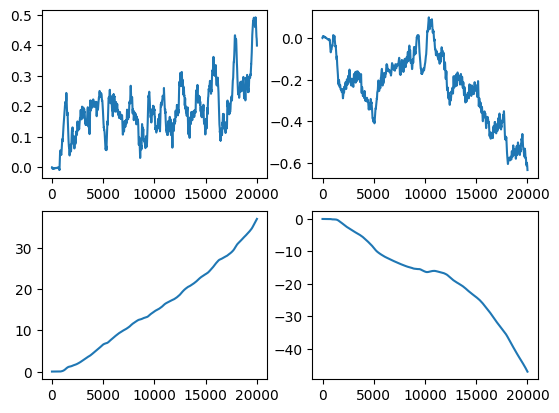

In [62]:
plt.subplot(2,2,1)
plt.plot(velocity_traj[0])
#plt.plot(targ[:,0])

plt.subplot(2,2,2)
plt.plot(velocity_traj[1])
#plt.plot(targ[:,0])

plt.subplot(2,2,3)
plt.plot(trajectory[0])
#plt.plot(gt_pos[:,0])

plt.subplot(2,2,4)
plt.plot(trajectory[1])
#plt.plot(gt_pos[:,0])

## Pedestrian Dead Reckoning

In [1]:
import argparse
import json
import os
import sys
from os import path as osp

import h5py
import matplotlib.pyplot as plt
import numpy as np
import quaternion
from scipy.interpolate import interp1d

#if want to search for packages from the parent file
#sys.path.append(osp.join(osp.dirname(osp.abspath(__file__)), '..'))

from math_util import *
from metric import compute_absolute_trajectory_error, compute_relative_trajectory_error



All done. Average ate:nan, average rte: nan


/usr/local/lib/python3.8/dist-packages/numpy/core/fromnumeric.py:3474: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/usr/local/lib/python3.8/dist-packages/numpy/core/_methods.py:189: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [ ]:
args = argparse.Namespace()
args.list = None
args.root_dir = None
args.align_length = 600
args.path = None
args.stride = 0.67
args.out_dir = None
args.show_plot = False





In [ ]:
root_dir, data_list = '', []
if args.path is not None:
    if args.path[-1] == '/':
        args.path = args.path[:-1]
    root_dir = osp.split(args.path)[0]
    data_list = [osp.split(args.path)[1]]
elif args.list is not None:
    root_dir = args.root_dir
    with open(args.list) as f:
        data_list = [s.strip().split()[0] for s in f.readlines() if len(s) > 0 and s[0] != '#']

if args.out_dir is not None and not osp.isdir(args.out_dir):
    os.makedirs(args.out_dir)

ate_all, rte_all = [], []
pred_per_min = 200 * 60

for data in data_list:
    data_path = osp.join(root_dir, data)
    with open(osp.join(data_path, 'info.json')) as f:
        info = json.load(f)
        device = info['device']
        rot_imu_to_tango = quaternion.quaternion(*info['start_calibration'])
        ref_time_imu = info['imu_reference_time']
        imu_time_offset = info['imu_time_offset']
        start_frame = info.get('start_frame', 0)

    with h5py.File(osp.join(data_path, 'data.hdf5')) as f:
        ori = np.copy(f['synced/game_rv'])
        tango_ori_q = quaternion.from_float_array(f['pose/tango_ori'])
        ori_q = quaternion.from_float_array(ori)
        init_rotor = tango_ori_q[0] * rot_imu_to_tango * ori_q[0].conj()
        ori = quaternion.as_float_array(init_rotor * ori_q)[start_frame:]

        ts = np.copy(f['synced/time'])[start_frame:]
        tango_pos = np.copy(f['pose/tango_pos'])[start_frame:]
        step = np.copy(f['raw/imu/step'])

    step_ts = step[:, 0] / 1e09 - imu_time_offset
    sid, eid = 0, step_ts.shape[0] - 1
    while sid < step_ts.shape[0] and ts[0] > step_ts[sid]:
        sid += 1
    while eid >= 0 and ts[-1] < step_ts[eid]:
        eid -= 1
    assert sid < step_ts.shape[0] and eid >= 0

    step_ts = step_ts[sid:eid + 1]
    step = step[sid:eid + 1]

    ori_at_step = interpolate_quaternion_linear(ori, ts, step_ts)
    yaw_at_step = orientation_to_angles(ori_at_step)[:, 0]

    rot_hori = np.stack([np.cos(yaw_at_step), np.sin(yaw_at_step),
                         -np.sin(yaw_at_step), np.cos(yaw_at_step)], axis=1).reshape([-1, 2, 2])
    step_v = np.stack([np.zeros(step.shape[0]), np.ones(step.shape[0]) * args.stride], axis=1)

    step_glob = np.squeeze(np.matmul(rot_hori, np.expand_dims(step_v, axis=2)), axis=2)
    pos_pred = np.zeros([step_glob.shape[0] + 1, 2])
    step_ts = np.concatenate([[ts[0]], step_ts], axis=0)
    pos_pred[0] = tango_pos[0][:2]
    pos_pred[1:] = np.cumsum(step_glob, axis=0) + pos_pred[0]

    eid = ts.shape[0] - 1
    while eid >= 0 and ts[eid] > step_ts[-1]:
        eid -= 1
    pos_gt = tango_pos[:eid + 1, :2]
    pos_pred = interp1d(step_ts, pos_pred, axis=0)(ts[:eid + 1])

    if args.align_length is not None and args.align_length > 0:
        _, r, t = icp_fit_transformation(pos_pred[:args.align_length], pos_gt[:args.align_length])
        pos_pred = np.matmul(r, pos_pred.T).T + t

    # For trajectories shorted than 1 min, we scale the RTE value accordingly.
    if pos_pred.shape[0] < pred_per_min:
        ratio = pred_per_min / pos_pred.shape[0]
        rte = compute_relative_trajectory_error(pos_pred, pos_gt, delta=pos_pred.shape[0] - 1) * ratio
    else:
        rte = compute_relative_trajectory_error(pos_pred, pos_gt, delta=pred_per_min)
    rte_all.append(rte)

    ate = compute_absolute_trajectory_error(pos_pred, pos_gt)
    ate_all.append(ate)
    print('Sequence {}, ate {:.6f}, rte {:.6f}'.format(data, ate, rte))

    plt.close('all')
    plt.figure(data, figsize=(8, 6))
    plt.plot(pos_gt[:, 0], pos_gt[:, 1])
    plt.plot(pos_pred[:, 0], pos_pred[:, 1])
    plt.legend(['Ground truth', 'Estimated'])
    plt.axis('equal')
    plt.tight_layout()

    if args.out_dir is not None and osp.isdir(args.out_dir):
        plt.savefig(osp.join(args.out_dir, data + '_pdr.png'))

    if args.show_plot:
        plt.show()

print('All done. Average ate:{:.6f}, average rte: {:.6f}'.format(np.mean(ate_all), np.mean(rte_all)))
if args.out_dir is not None and osp.isdir(args.out_dir):
    with open(osp.join(args.out_dir, 'result.csv'), 'w') as f:
        f.write('seq,ate,rte\n')
        for i in range(len(data_list)):
            f.write('{},{:.6f},{:.6f}\n'.format(data_list[i], ate_all[i], rte_all[i]))